In [15]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd

In [41]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [7]:
# query into the Data structure of Measurement
from sqlalchemy import inspect
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [81]:
# Calculate the date 1 year ago from the last data point in the database
from datetime import datetime
last_date = session.query(func.max(Measurement.date)).all()[0][0]
first_date = datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days = 365)
print(first_date)

2016-08-23 00:00:00


In [209]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
                  filter(Measurement.date <= last_date).\
                  filter(Measurement.date >= first_date).\
                  order_by(Measurement.date).all()              


In [104]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
hawaii_prcp = pd.DataFrame(results, columns = ['date', 'preciputation'])
hawaii_prcp.set_index('date', inplace = True)
hawaii_prcp_date = hawaii_prcp.groupby(['date']).sum()
hawaii_prcp_date.head()

,preciputation
date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


<Figure size 720x432 with 0 Axes>

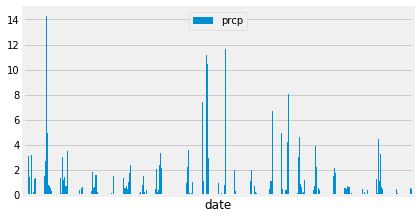

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure()
fig.set_size_inches((10, 6))
hawaii_prcp_date.plot.bar()
plt.legend(loc = 'upper center')
plt.tight_layout()
plt.xticks([])
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
hawaii_prcp.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [248]:
# Design a query to show how many stations are available in this dataset?
station_no = session.query(Measurement.station).group_by(Measurement.station).count()
station_no

9

In [249]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.id)).\
              group_by(Measurement.station).\
              order_by(func.count(Measurement.id).desc()).all()

for row in results:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [250]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_temp = session.query(Measurement.tobs).\
              filter_by(station = 'USC00519281').\
              order_by(Measurement.tobs).first()
highest_temp = session.query(Measurement.tobs).\
              filter_by(station = 'USC00519281').\
              order_by(Measurement.tobs.desc()).first()
mean_temp = session.query(func.avg(Measurement.tobs)).\
             filter_by(station = 'USC00519281').all()
                          
print([lowest_temp[0], highest_temp[0], mean_temp[0][0]])

[54.0, 85.0, 71.66378066378067]


In [252]:
# Choose the station with the highest number of temperature observations.
busy_station = session.query(Measurement.station).\
           group_by(Measurement.station).\
           order_by(func.count(Measurement.tobs).desc()).first()[0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
          filter_by(station =busy_station).\
          filter(Measurement.date <= last_date).\
          filter(Measurement.date >= first_date).\
                  order_by(Measurement.date).all()              
busy_station_tobs = pd.DataFrame(results, columns = ['tobs'],  figsize=(7,5))
busy_station_tobs.hist(bins =11)

plt.ylabel('frequency')
plt.tight_layout()

TypeError: __init__() got an unexpected keyword argument 'figsize'

In [151]:
date = datetime.strptime('02-28', "%m-%d")
date.month


2

In [101]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    start_date = datetime.strptime(start_date, "%Y-%m-%d") 
    end_date = datetime.strptime(end_date, "%Y-%m-%d") 
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.4375, 74.0)]


In [158]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2017-07-01', '2017-07-07')
print(trip_temp)

[(74.0, 78.27777777777777, 87.0)]


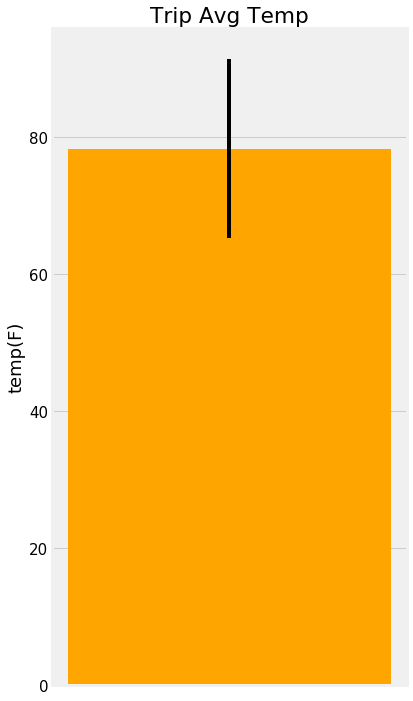

In [160]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
from matplotlib import rcParams

plt.rcParams["figure.figsize"] = (6,10)
yerr = trip_temp[0][2] - trip_temp[0][0]
plt.bar(1, trip_temp[0][1], yerr = yerr, color = 'orange')

rcParams.update({'font.size': 15})
plt.title('Trip Avg Temp')
plt.ylabel('temp(F)')
plt.xticks([])
plt.tight_layout()

In [138]:
from sqlalchemy import inspect
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [145]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = session.query(func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
          filter(Measurement.station == Station.station).\
          group_by(Measurement.station).\
          order_by(func.sum(Measurement.prcp).desc()).all()

Rainfall_station_sort = pd.DataFrame(results, columns = ['precipitation', 'station', 'name', 'latitude', 'longitude', 'elevation'])
Rainfall_station_sort

,precipitation,station,name,latitude,longitude,elevation
0,1068.09,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,588.64,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,382.62,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,295.68,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,234.49,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,131.62,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,92.68,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
7,70.87,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
8,43.44,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [157]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")
   

[(62.0, 69.15384615384616, 77.0)]

In [198]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [201]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2018-07-01'
end_date = '2018-07-07'

# Use the start and end date to create a range of dates
start = date.strptime(start_date, "%Y-%m-%d")
end = datetime.strptime(end_date, "%Y-%m-%d") + dt.timedelta(days=1)
trip = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

# Stip off the year and save a list of %m-%d strings
trip_date = [f"{str(day.month).zfill(2)}-{str(day.day).zfill(2)}" for day in trip]

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_weather_results = [daily_normals(day) for day in trip_date]

In [225]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_weather = pd.DataFrame(trip_weather_results, columns = ['tmin', 'tavg', 'tmax'])
date = [f"{str(day.year)}-{str(day.month).zfill(2)}-{str(day.day).zfill(2)}" for day in trip]
trip_weather['date'] = date
trip_weather.set_index('date', inplace = True)
trip_weather

,tmin,tavg,tmax
date,,,
2018-07-01,67.0,74.777778,81.0
2018-07-02,68.0,75.403846,82.0
2018-07-03,68.0,75.320755,87.0
2018-07-04,70.0,76.571429,81.0
2018-07-05,66.0,75.000000,81.0
2018-07-06,69.0,75.000000,81.0
2018-07-07,69.0,74.910714,82.0


(array([0., 1., 2., 3., 4., 5., 6.]), <a list of 7 Text xticklabel objects>)

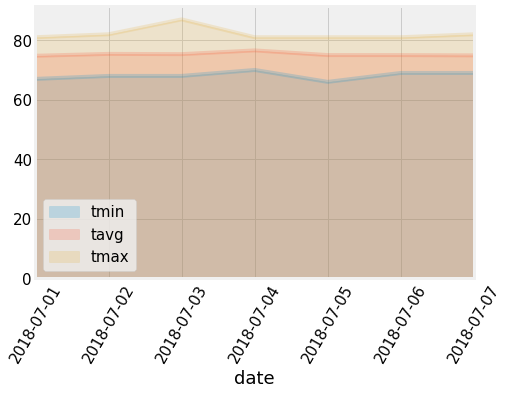

In [246]:
# Plot the daily normals as an area plot with `stacked=False`

trip_weather.plot.area(alpha =0.2, stacked=False, figsize=(7,5))
plt.xticks(rotation = 60)
